In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
# Add src folder to the Python path
sys.path.append(os.path.abspath("../src"))

In [30]:
from simulator import simulate_paths
from params import param_assign

model = "KJD"
T = 1
nsteps = 252
nsim = 100_000
dt = T / nsteps
params = param_assign(model)

paths = simulate_paths(model, nsteps, nsim, dt, seed=42)

In [31]:
from payoff import autocallable_payoff

call_dates = [63, 126, 189, 252]  # Quarterly observation dates
payoffs, call_flags = autocallable_payoff(paths, call_dates)

In [33]:
r = 0.02  # risk-free rate
T = 1     # in years
price = np.exp(-r * T) * np.mean(p)
print(f"Fair Price of the Autocallable: {price:.4f}")

Fair Price of the Autocallable: 92.2018


In [34]:
import numpy as np

# Discounted price
price = np.exp(-r * T) * np.mean(payoffs)

# 95% Confidence Interval
stderr = np.exp(-r * T) * np.std(payoffs) / np.sqrt(len(payoffs))
ci_low = price - 1.96 * stderr
ci_high = price + 1.96 * stderr

print(f"\n💰 Monte Carlo Price: {price:.4f}")
print(f"📊 95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"📉 Standard Error: {stderr:.6f}")


💰 Monte Carlo Price: 87.6635
📊 95% Confidence Interval: [87.4317, 87.8953]
📉 Standard Error: 0.118257


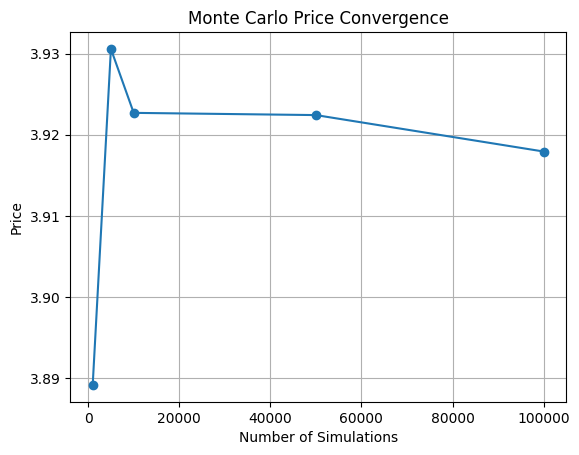

In [27]:
sim_counts = [1_000, 5_000, 10_000, 50_000, 100_000]
prices = []

for nsim in sim_counts:
    paths = simulate_paths(model, nsteps, nsim, dt, seed=42)
    payoffs, _ = autocallable_payoff(paths, call_dates)
    price = np.exp(-r * T) * np.mean(payoffs)
    prices.append(price)

plt.plot(sim_counts, prices, marker="o")
plt.title("Monte Carlo Price Convergence")
plt.xlabel("Number of Simulations")
plt.ylabel("Price")
plt.grid(True)
plt.show()

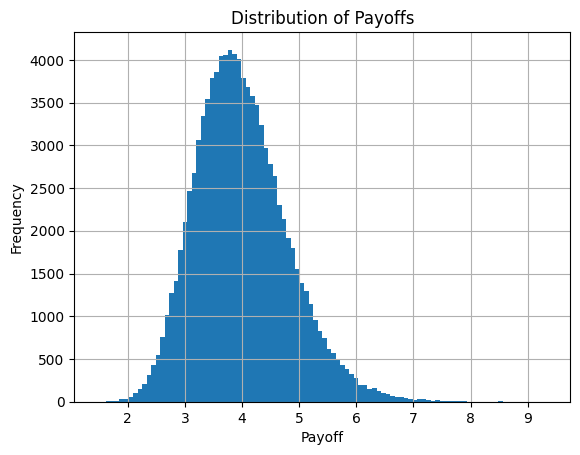

In [28]:
plt.hist(payoffs, bins=100)
plt.title("Distribution of Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.grid(True)

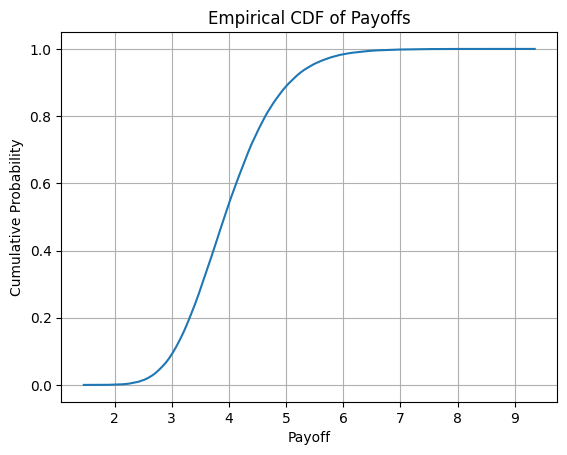

In [29]:

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(payoffs)
x = np.linspace(min(payoffs), max(payoffs), 500)
plt.plot(x, ecdf(x))
plt.title("Empirical CDF of Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Cumulative Probability")
plt.grid(True)

In [1]:
import numpy as np

def simulate_gbm_paths(S0, r, sigma, T, N, M):
    dt = T / N
    Z = np.random.standard_normal((M, N))
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    return S

In [2]:
def check_parisian_barrier(S, B, D, dt):
    M, N_plus_1 = S.shape
    barrier_breached = np.zeros(M, dtype=bool)
    for i in range(M):
        count = 0
        for t in range(1, N_plus_1):
            if S[i, t] > B:
                count += 1
                if count * dt >= D:
                    barrier_breached[i] = True
                    break
            else:
                count = 0
    return barrier_breached

In [3]:
def calculate_payoffs(S, K, r, T, barrier_breached):
    M = S.shape[0]
    payoffs = np.zeros(M)
    for i in range(M):
        if barrier_breached[i]:
            payoffs[i] = max(S[i, -1] - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    return discounted_payoffs

Estimated Parisian Barrier Option Price: 6.6683


In [7]:
def simulate_antithetic_paths(S0, r, sigma, T, N, M):
    dt = T / N
    Z = np.random.standard_normal((M, N))
    Z_antithetic = -Z
    S = np.zeros((2*M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        Z_combined = np.vstack((Z, Z_antithetic))
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_combined[:, t - 1])
    return S

In [8]:
def control_variate_adjustment(payoffs, S, K, r, T):
    # Analytical price of European call option
    from scipy.stats import norm

    S0 = S[0, 0]
    sigma = np.std(np.log(S[:, 1:] / S[:, :-1])) / np.sqrt(T / S.shape[1])
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price_analytical = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    # Simulated European call option price
    call_payoffs = np.maximum(S[:, -1] - K, 0)
    call_price_simulated = np.exp(-r * T) * np.mean(call_payoffs)

    # Adjust payoffs
    adjusted_payoffs = payoffs + (call_price_analytical - call_price_simulated)
    return adjusted_payoffs

In [9]:
def importance_sampling_paths(S0, r, sigma, T, N, M, mu_shift):
    dt = T / N
    Z = np.random.standard_normal((M, N))
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2 + mu_shift) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    # Likelihood ratio for importance sampling
    likelihood_ratio = np.exp(-mu_shift * np.sum(Z, axis=1) * sigma * np.sqrt(dt) - 0.5 * mu_shift ** 2 * T)
    return S, likelihood_ratio

In [10]:
def brownian_bridge_adjustment(S, B, dt):
    M, N_plus_1 = S.shape
    adjusted_barrier_breached = np.zeros(M, dtype=bool)
    for i in range(M):
        for t in range(1, N_plus_1):
            min_S = min(S[i, t - 1], S[i, t])
            max_S = max(S[i, t - 1], S[i, t])
            if min_S < B < max_S:
                # Estimate the probability of crossing the barrier between t-1 and t
                prob_cross = np.exp(-2 * (B - S[i, t - 1]) * (B - S[i, t]) / (sigma ** 2 * dt))
                if np.random.rand() < prob_cross:
                    adjusted_barrier_breached[i] = True
                    break
    return adjusted_barrier_breached

In [11]:
# Parameters
S0 = 70
K = 75
B = 80
r = 0.02
sigma = 0.3
T = 1
N = 252
M = 10000
D = 5 / 252  # Parisian delay
mu_shift = 0.1  # For importance sampling

# Time step
dt = T / N

# Simulate Antithetic Paths
S_antithetic = simulate_antithetic_paths(S0, r, sigma, T, N, M // 2)  # M doubled inside

# Importance Sampling
S_importance, likelihood_ratio = importance_sampling_paths(S0, r, sigma, T, N, M, mu_shift)

# Brownian Bridge adjusted barrier hits
barrier_breached = brownian_bridge_adjustment(S_importance, B, dt)

# Compute Payoffs
payoffs = calculate_payoffs(S_importance, K, r, T, barrier_breached)

# Apply likelihood ratio for importance sampling
adjusted_payoffs = payoffs * likelihood_ratio

# Control Variate Adjustment
adjusted_payoffs = control_variate_adjustment(adjusted_payoffs, S_importance, K, r, T)

# Estimate Option Price
option_price = np.mean(adjusted_payoffs)
print(f"Estimated Parisian Barrier Option Price (with variance reduction): {option_price:.4f}")


/var/folders/gh/dbcs37ys7mv_5ptqmf4b9l880000gn/T/ipykernel_27884/3241017581.py:10: RuntimeWarning: overflow encountered in exp
  prob_cross = np.exp(-2 * (B - S[i, t - 1]) * (B - S[i, t]) / (sigma ** 2 * dt))


Estimated Parisian Barrier Option Price (with variance reduction): 6.4292


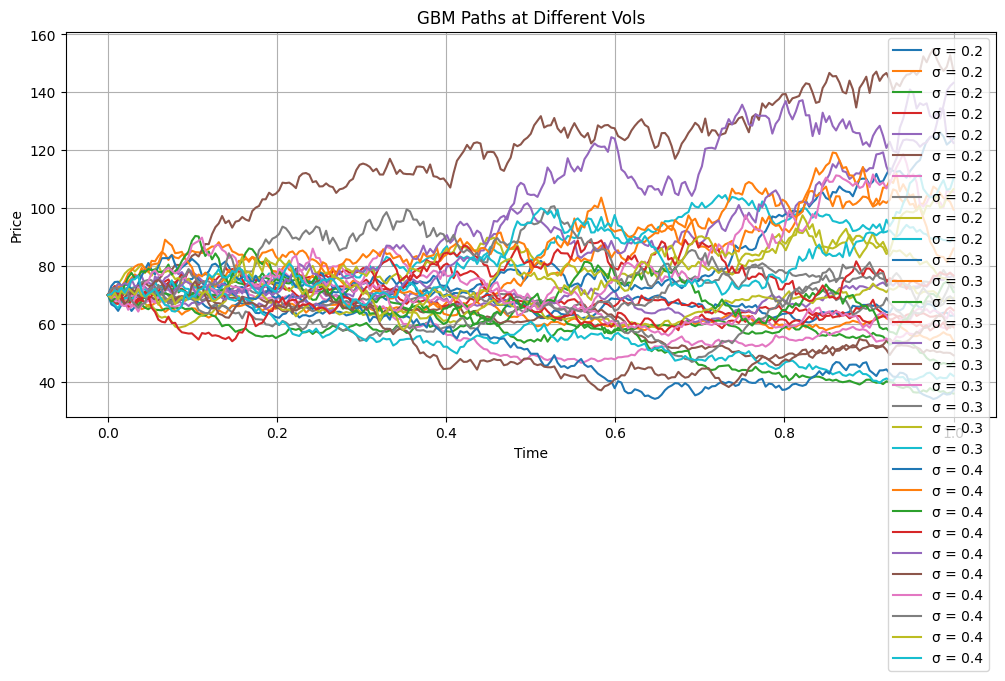

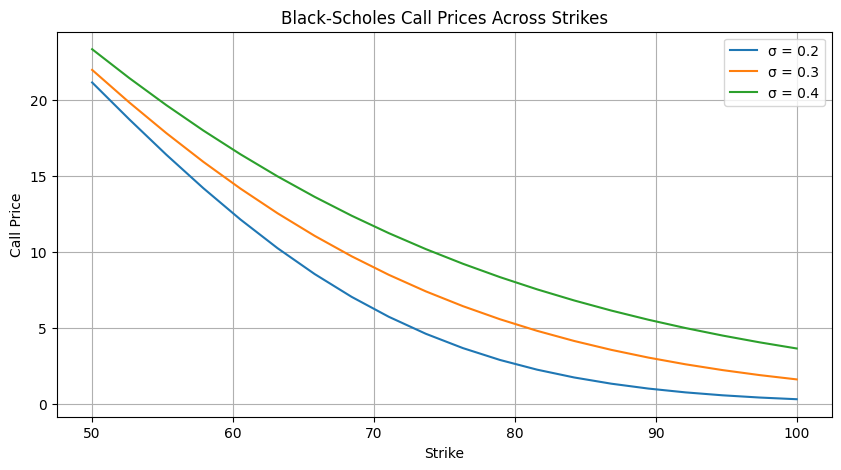

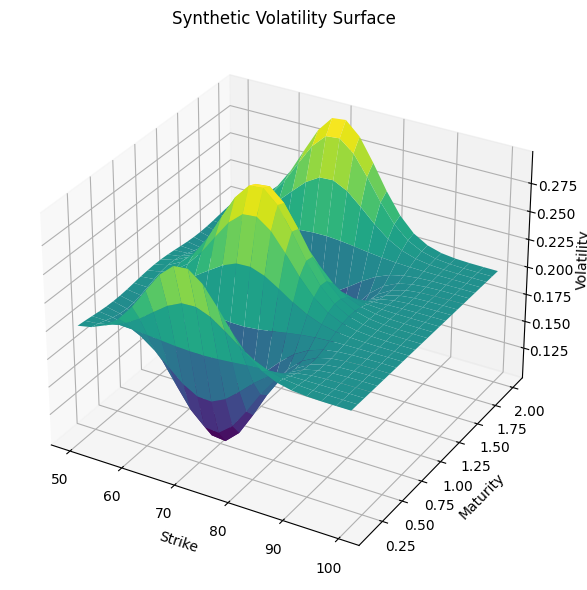

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters ---
S0 = 70
r = 0.02
T = 1
N = 252
dt = T / N
sigmas = [0.2, 0.3, 0.4]
strikes = np.linspace(50, 100, 20)
maturities = np.linspace(0.1, 2.0, 25)

# --- Simulate GBM Paths ---
def simulate_gbm(S0, r, sigma, T, N, M):
    Z = np.random.randn(N, M)
    paths = np.zeros((N + 1, M))
    paths[0] = S0
    for t in range(1, N + 1):
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t - 1])
    return paths

plt.figure(figsize=(12, 5))
for sigma in sigmas:
    paths = simulate_gbm(S0, r, sigma, T, N, 10)
    plt.plot(np.linspace(0, T, N + 1), paths, label=f'σ = {sigma}')
plt.title("GBM Paths at Different Vols")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Black-Scholes Call Price ---
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# --- Volatility Smile (Toy Example) ---
plt.figure(figsize=(10, 5))
for sigma in sigmas:
    prices = [black_scholes_call(S0, K, T, r, sigma) for K in strikes]
    plt.plot(strikes, prices, label=f'σ = {sigma}')
plt.title("Black-Scholes Call Prices Across Strikes")
plt.xlabel("Strike")
plt.ylabel("Call Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Volatility Surface (Synthetic) ---
S_grid, T_grid = np.meshgrid(strikes, maturities)
vol_surface = 0.2 + 0.1 * np.exp(-((S_grid - S0)**2 / 100)) * np.cos(2 * np.pi * T_grid)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, vol_surface, cmap='viridis')
ax.set_title("Synthetic Volatility Surface")
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("Volatility")
plt.tight_layout()
plt.show()

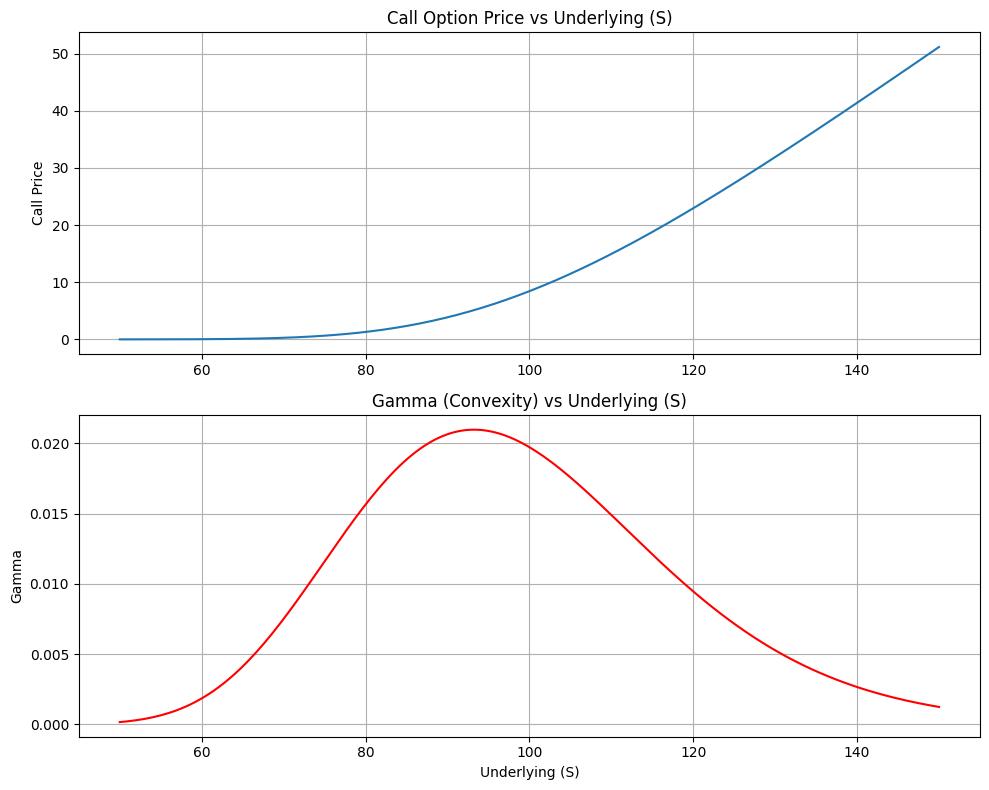

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
K = 100
r = 0.01
T = 1.0
sigma = 0.2
S = np.linspace(50, 150, 200)

# Black-Scholes d1 and d2
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

# Call price
def call_price(S, K, T, r, sigma):
    d_1 = d1(S, K, T, r, sigma)
    d_2 = d2(S, K, T, r, sigma)
    return S * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2)

# Gamma (Convexity)
def gamma(S, K, T, r, sigma):
    d_1 = d1(S, K, T, r, sigma)
    return norm.pdf(d_1) / (S * sigma * np.sqrt(T))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(S, call_price(S, K, T, r, sigma))
ax[0].set_title("Call Option Price vs Underlying (S)")
ax[0].set_ylabel("Call Price")
ax[0].grid()

ax[1].plot(S, gamma(S, K, T, r, sigma), color='red')
ax[1].set_title("Gamma (Convexity) vs Underlying (S)")
ax[1].set_ylabel("Gamma")
ax[1].set_xlabel("Underlying (S)")
ax[1].grid()

plt.tight_layout()
plt.show()